<a href="https://www.kaggle.com/code/akscent/fitmlforcharn-prediction?scriptVersionId=152179596" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pprint import pprint
from warnings import filterwarnings

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

filterwarnings("ignore", category=pd.errors.PerformanceWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=Warning)
filterwarnings("ignore", category=DeprecationWarning)



In [2]:
# Check if GPU is available
try:
    import cupy as cp
    gpu_available = True
except ImportError:
    gpu_available = False

# Set n_jobs parameter for classifiers that support it
n_jobs = -1 if gpu_available else 1

# Load data

In [3]:
train_df = pd.read_parquet('/kaggle/input/sibalfahack/Siberian Alfa Hack Materials/train.parquet')
test_df = pd.read_parquet('/kaggle/input/sibalfahack/Siberian Alfa Hack Materials/test.parquet')

In [4]:
num_cols = [
       'sum_b_oper_3m', 'cnt_b_oper_3m', 'sum_c_oper_3m', 'cnt_c_oper_3m',
       'sum_deb_d_oper_3m', 'cnt_deb_d_oper_3m', 'sum_cred_d_oper_3m',
       'cnt_cred_d_oper_3m', 'sum_deb_e_oper_3m', 'cnt_deb_e_oper_3m',
       'cnt_days_deb_e_oper_3m', 'sum_cred_e_oper_3m', 'cnt_cred_e_oper_3m',
       'cnt_days_cred_e_oper_3m', 'sum_deb_f_oper_3m', 'cnt_deb_f_oper_3m',
       'cnt_days_deb_f_oper_3m', 'sum_cred_f_oper_3m', 'cnt_cred_f_oper_3m',
       'cnt_days_cred_f_oper_3m', 'sum_deb_g_oper_3m', 'cnt_deb_g_oper_3m',
       'cnt_days_deb_g_oper_3m', 'sum_cred_g_oper_3m', 'cnt_cred_g_oper_3m',
       'cnt_days_cred_g_oper_3m', 'sum_deb_h_oper_3m', 'cnt_deb_h_oper_3m',
       'cnt_days_deb_h_oper_3m', 'sum_cred_h_oper_3m', 'cnt_cred_h_oper_3m',
       'cnt_days_cred_h_oper_3m'
]

# cat_cols = [
#     "Sex",
#     "IsSeniorCitizen",
#     "HasPartner",
#     "HasChild",
#     "HasPhoneService",
#     "HasMultiplePhoneNumbers",
#     "HasInternetService",
#     "HasOnlineSecurityService",
#     "HasOnlineBackup",
#     "HasDeviceProtection",
#     "HasTechSupportAccess",
#     "HasOnlineTV",
#     "HasMovieSubscription",
#     "HasContractPhone",
#     "IsBillingPaperless",
#     "PaymentMethod",
# ]

target = 'total_target'

In [5]:
train_df = pd.concat([train_df[num_cols], train_df[target]], axis = 1)
train_df

,sum_b_oper_3m,cnt_b_oper_3m,sum_c_oper_3m,cnt_c_oper_3m,sum_deb_d_oper_3m,cnt_deb_d_oper_3m,sum_cred_d_oper_3m,cnt_cred_d_oper_3m,sum_deb_e_oper_3m,cnt_deb_e_oper_3m,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,total_target
0,643.766096,0.924035,6.930739,0.747401,370.243552,0.183266,27.413391,0.218645,4.393475e+05,19.822407,...,1.186720e+01,-0.354446,0.064993,3.319602e+04,1.229488,0.396969,3.235240e+05,12.420855,9.069157,1
1,643.766096,0.924035,7.141910,0.695312,370.243552,0.881256,27.267744,0.218645,4.919733e+05,19.564821,...,1.204940e+01,0.358222,0.270542,3.319549e+04,1.229488,-0.137339,1.456416e+05,2.124925,2.069157,0
2,643.766096,0.924035,6.517859,0.851319,370.243552,0.263782,27.362654,0.218645,7.009577e+06,87.265604,...,6.374099e+06,29.426595,23.431839,2.650712e+05,4.229488,3.595162,1.257271e+05,0.999583,1.069157,0
3,643.766096,0.924035,6.879688,0.511175,370.243552,0.624099,27.749850,0.218645,9.883151e+05,37.335591,...,1.153105e+01,0.074660,0.990581,4.950943e+05,9.229488,8.582252,3.703923e+05,3.066714,3.069157,0
4,643.766096,0.924035,6.513118,0.788958,370.243552,0.514792,27.124360,0.218645,2.435510e+05,9.460940,...,1.232242e+01,0.447267,0.393927,3.319632e+04,1.229488,0.276606,1.257268e+05,1.219935,1.069157,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,643.766096,0.924035,6.795117,0.476576,370.243552,0.430343,26.889879,0.218645,2.503229e+06,63.440102,...,1.224405e+01,0.415840,0.177506,2.038701e+06,51.229488,22.182922,2.006430e+05,3.963913,2.069157,0
359996,643.766096,0.924035,7.176629,1.307246,370.243552,-0.346636,27.217364,0.218645,2.279753e+05,7.590312,...,1.203573e+01,0.546852,0.301299,3.319599e+04,1.229488,0.225770,1.257279e+05,1.114018,1.069157,0
359997,643.766096,0.924035,6.625929,0.572423,146330.551423,12.457951,26.759747,0.218645,1.021222e+07,120.528255,...,1.208514e+01,0.101792,0.150675,2.151680e+05,16.229488,8.413681,1.309472e+07,5.397099,5.069157,0
359998,643.766096,0.924035,6.891384,1.025830,370.243552,0.477021,27.689288,0.218645,1.961004e+07,408.462831,...,2.851429e+06,84.151652,53.062204,1.874074e+07,353.229488,58.237079,1.078043e+07,294.991216,67.069157,0


In [6]:
train_df.dropna(inplace=True)

# Choose model

* Используем choos model из предыдущей работы - расширенный - https://www.kaggle.com/code/akscent/choice-of-boosting
* Отличный ноутбук с оценкой и ансамблированием моделей - https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
* Далее оптимизаторы гиперпараметр**ов - https://www.kaggle.com/code/akscent/ods-boosting
* Далее стекинг - https://www.kaggle.com/code/akscent/ods-boosting ; https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/ ; https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/6.3%20-%20Automatic%20Stacking.ipynb

In [7]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from tqdm.notebook import tqdm

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline

In [8]:
train_df[num_cols]

,sum_b_oper_3m,cnt_b_oper_3m,sum_c_oper_3m,cnt_c_oper_3m,sum_deb_d_oper_3m,cnt_deb_d_oper_3m,sum_cred_d_oper_3m,cnt_cred_d_oper_3m,sum_deb_e_oper_3m,cnt_deb_e_oper_3m,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m
0,643.766096,0.924035,6.930739,0.747401,370.243552,0.183266,27.413391,0.218645,4.393475e+05,19.822407,...,0.515331,1.186720e+01,-0.354446,0.064993,3.319602e+04,1.229488,0.396969,3.235240e+05,12.420855,9.069157
1,643.766096,0.924035,7.141910,0.695312,370.243552,0.881256,27.267744,0.218645,4.919733e+05,19.564821,...,0.497933,1.204940e+01,0.358222,0.270542,3.319549e+04,1.229488,-0.137339,1.456416e+05,2.124925,2.069157
2,643.766096,0.924035,6.517859,0.851319,370.243552,0.263782,27.362654,0.218645,7.009577e+06,87.265604,...,23.154435,6.374099e+06,29.426595,23.431839,2.650712e+05,4.229488,3.595162,1.257271e+05,0.999583,1.069157
3,643.766096,0.924035,6.879688,0.511175,370.243552,0.624099,27.749850,0.218645,9.883151e+05,37.335591,...,9.378362,1.153105e+01,0.074660,0.990581,4.950943e+05,9.229488,8.582252,3.703923e+05,3.066714,3.069157
4,643.766096,0.924035,6.513118,0.788958,370.243552,0.514792,27.124360,0.218645,2.435510e+05,9.460940,...,1.944106,1.232242e+01,0.447267,0.393927,3.319632e+04,1.229488,0.276606,1.257268e+05,1.219935,1.069157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,643.766096,0.924035,6.795117,0.476576,370.243552,0.430343,26.889879,0.218645,2.503229e+06,63.440102,...,1.686092,1.224405e+01,0.415840,0.177506,2.038701e+06,51.229488,22.182922,2.006430e+05,3.963913,2.069157
359996,643.766096,0.924035,7.176629,1.307246,370.243552,-0.346636,27.217364,0.218645,2.279753e+05,7.590312,...,0.701205,1.203573e+01,0.546852,0.301299,3.319599e+04,1.229488,0.225770,1.257279e+05,1.114018,1.069157
359997,643.766096,0.924035,6.625929,0.572423,146330.551423,12.457951,26.759747,0.218645,1.021222e+07,120.528255,...,1.402768,1.208514e+01,0.101792,0.150675,2.151680e+05,16.229488,8.413681,1.309472e+07,5.397099,5.069157
359998,643.766096,0.924035,6.891384,1.025830,370.243552,0.477021,27.689288,0.218645,1.961004e+07,408.462831,...,0.459084,2.851429e+06,84.151652,53.062204,1.874074e+07,353.229488,58.237079,1.078043e+07,294.991216,67.069157


In [9]:
df_target_0 = train_df[train_df['total_target'] == 0].head(25000)
df_target_1 = train_df[train_df['total_target'] == 1].head(25000)

train_df = pd.concat([df_target_0, df_target_1], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_classification_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


ML first estimate:   0%|          | 0/7 [00:00<?, ?it/s]

AdaBoostClassifier estimated: 0.7512000000000001
Classification Report for AdaBoostClassifier:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76     26094
           1       0.73      0.76      0.75     23906

    accuracy                           0.75     50000
   macro avg       0.75      0.75      0.75     50000
weighted avg       0.75      0.75      0.75     50000



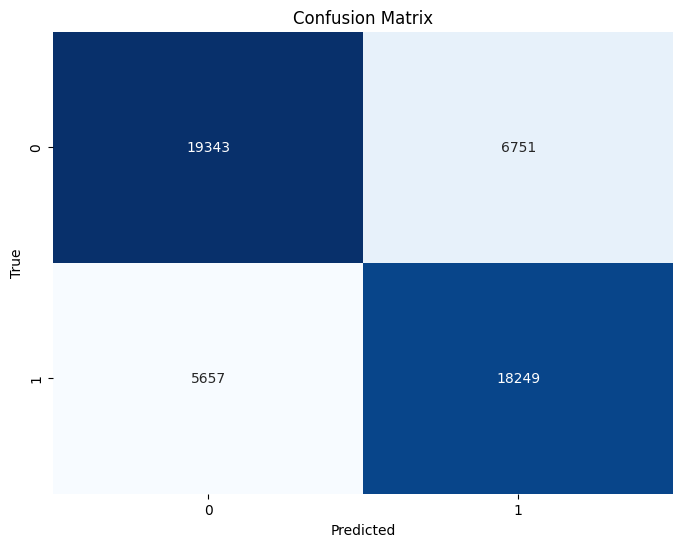

ExtraTreesClassifier estimated: 0.77724
Classification Report for ExtraTreesClassifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25000
           1       1.00      1.00      1.00     25000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



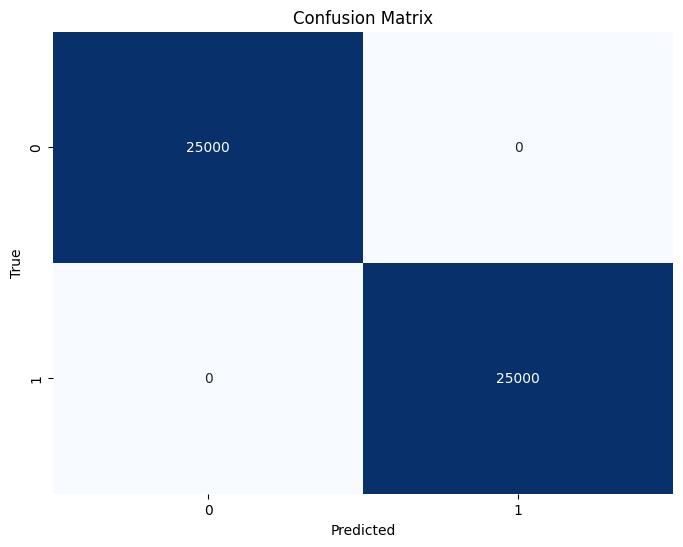

KNeighborsClassifier estimated: 0.71724
Classification Report for KNeighborsClassifier:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80     24208
           1       0.82      0.80      0.81     25792

    accuracy                           0.81     50000
   macro avg       0.81      0.81      0.81     50000
weighted avg       0.81      0.81      0.81     50000



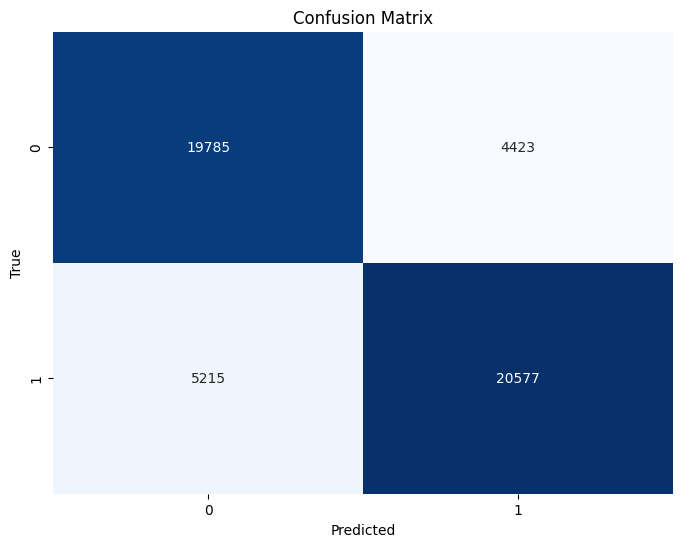

ExtraTreeClassifier estimated: 0.6896000000000001
Classification Report for ExtraTreeClassifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25000
           1       1.00      1.00      1.00     25000

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



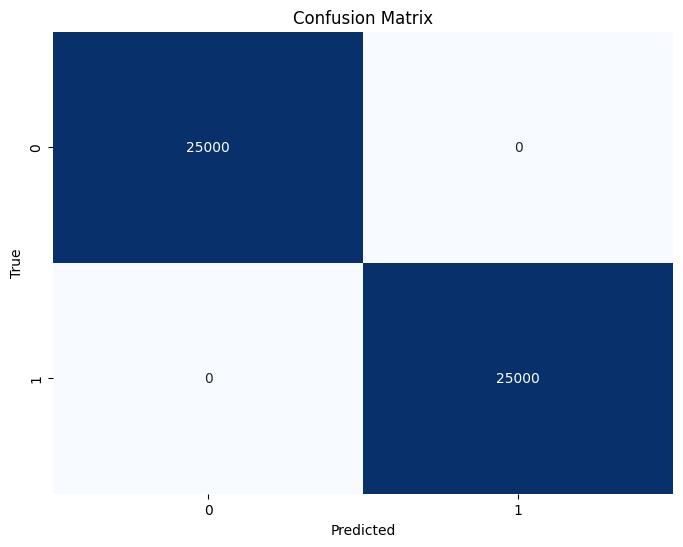

XGBClassifier estimated: 0.76656
Classification Report for XGBClassifier:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86     24658
           1       0.87      0.86      0.86     25342

    accuracy                           0.86     50000
   macro avg       0.86      0.86      0.86     50000
weighted avg       0.86      0.86      0.86     50000



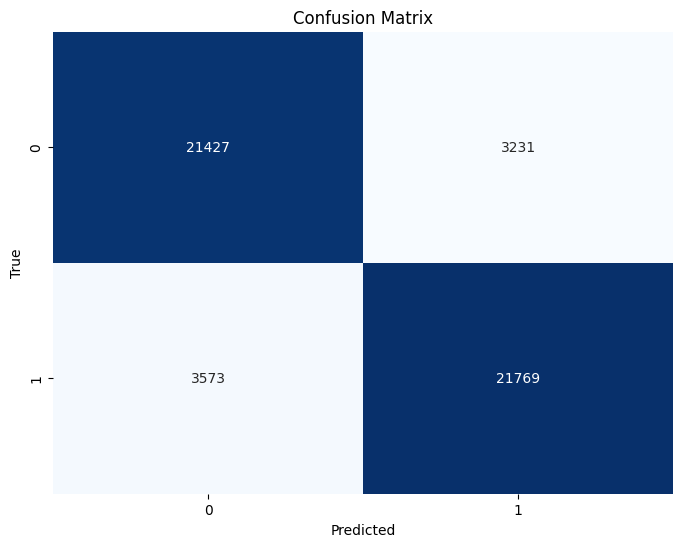

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006007 seconds.
You can set `force_col_wise=true` to remove the overhead.
LGBMClassifier estimated: 0.77288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013956 seconds.
You can set `force_col_wise=true` 

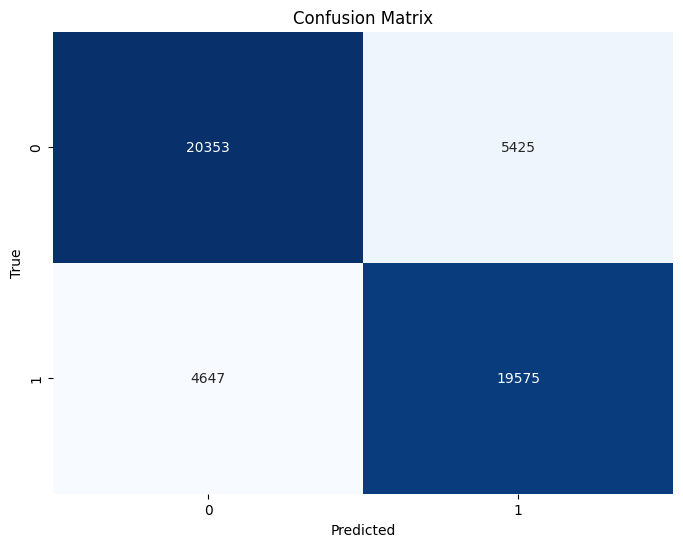

CatBoostClassifier estimated: 0.77416
Classification Report for CatBoostClassifier:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83     25363
           1       0.82      0.84      0.83     24637

    accuracy                           0.83     50000
   macro avg       0.83      0.83      0.83     50000
weighted avg       0.83      0.83      0.83     50000



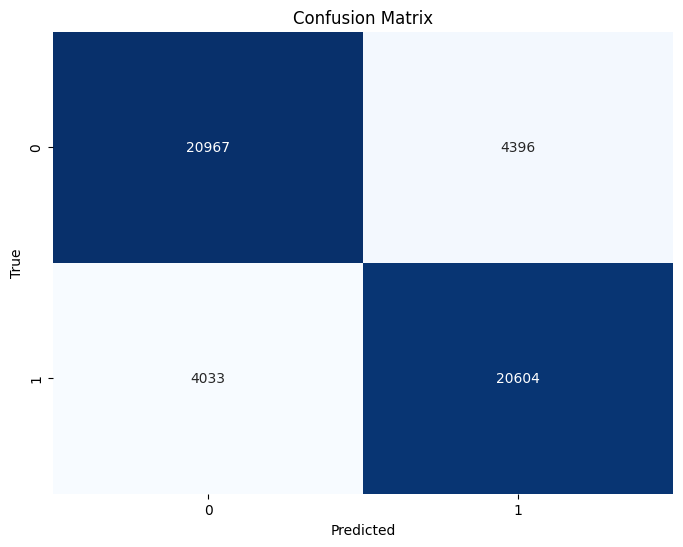

Text(0, 0.5, 'Algorithm')

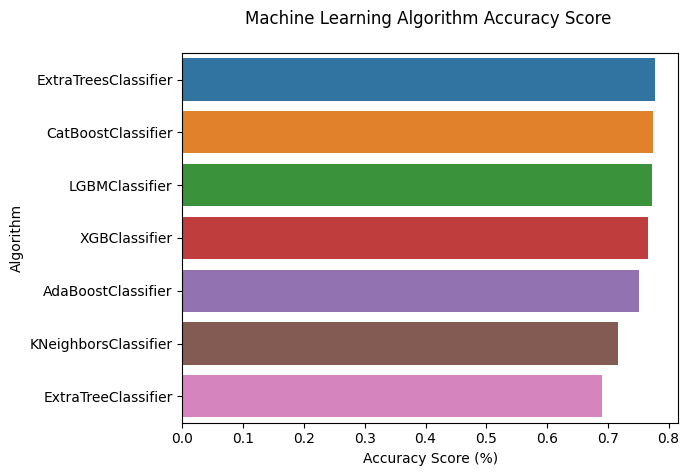

In [11]:
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(n_jobs=n_jobs, verbose = 0),

    # GLM
#     linear_model.LogisticRegressionCV(),
#     linear_model.PassiveAggressiveClassifier(n_jobs=n_jobs),
#     linear_model.RidgeClassifierCV(),
#     linear_model.SGDClassifier(n_jobs=n_jobs),
#     linear_model.Perceptron(n_jobs=n_jobs),

    # Navies Bayes
#     naive_bayes.BernoulliNB(),
#     naive_bayes.GaussianNB(),

    # Nearest Neighbor
    neighbors.KNeighborsClassifier(n_jobs=n_jobs),

    # SVM
#     svm.SVC(probability=True),
#     svm.NuSVC(probability=True),
#     svm.LinearSVC(),

    # Trees
#     tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Discriminant Analysis
#     discriminant_analysis.LinearDiscriminantAnalysis(),
#     discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # xgboost
    XGBClassifier(tree_method='gpu_hist') if gpu_available else XGBClassifier(verbose = 0),

    # LightGBM
    LGBMClassifier(device_type='gpu') if gpu_available else LGBMClassifier(verbose = 0),

    # CatBoost
    CatBoostClassifier(task_type='GPU') if gpu_available else CatBoostClassifier(verbose = 0)
]

def evaluate_ml_algorithms(MLA, data, data_x, target, cv_splits=5, test_size=0.1, train_size=0.4, random_state=43):
    MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
    MLA_compare = pd.DataFrame(columns=MLA_columns)
    
    MLA_predict = data[target]
    
    cv_split = model_selection.StratifiedShuffleSplit(n_splits=cv_splits, test_size=test_size, train_size=train_size, random_state=random_state)

    row_index = 0
    for alg in  tqdm(MLA, total=len(MLA), desc="ML first estimate"):
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
        
        cv_results = model_selection.cross_validate(alg, data[data_x], data[target], cv=cv_split, return_train_score = True)
        print(f"{MLA_name} estimated: {cv_results['test_score'].mean()}")
        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
        MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3
        alg.fit(data[data_x], data[target])
        MLA_predict[MLA_name] = alg.predict(data[data_x])
        evaluate_classification_metrics(MLA_predict[MLA_name], data[target], MLA_name)
        
        row_index += 1

    MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
    
    return MLA_compare

result = evaluate_ml_algorithms(MLA, train_df, num_cols, target)

sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = result)
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [12]:
result["MLA Test Accuracy Mean"] = result["MLA Test Accuracy Mean"].astype(float)
list_best_models = list(result.nlargest(4, 'MLA Test Accuracy Mean')["MLA Name"])

In [13]:
list_best_models

['ExtraTreesClassifier',
 'CatBoostClassifier',
 'LGBMClassifier',
 'XGBClassifier']

# Search hyperparams

In [41]:
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score
    
# Определение функции objective
def objective(trial, X, y, MLA, model_name):
# Список гиперпараметров для каждой модели
    MLA_params = [
        {'name': 'AdaBoost', 'params': {'n_estimators': trial.suggest_int('n_estimators', 2000, 5000), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),}},
    #     {'name': 'BaggingClassifier', 'params': {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 0.7, 1.0]}},
    #     {'name': 'ExtraTrees', 'params': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2']}},
    #     {'name': 'GradientBoosting', 'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}},
    #     {'name': 'RandomForest', 'params': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2']}},
    #     {'name': 'LogisticRegressionCV', 'params': {'Cs': [1, 10, 100], 'penalty': ['l1', 'l2']}},
    #     {'name': 'PassiveAggressiveClassifier', 'params': {'C': [0.1, 1, 10], 'max_iter': [100, 200, 500]}},
    #     {'name': 'RidgeClassifierCV', 'params': {'alphas': [(1e-3, 1e-2, 1e-1), (1, 10, 100)]}},
    #     {'name': 'SGDClassifier', 'params': {'alpha': [1e-3, 1e-2, 1e-1], 'max_iter': [100, 200, 500]}},
    #     {'name': 'Perceptron', 'params': {'alpha': [1e-3, 1e-2, 1e-1], 'max_iter': [100, 200, 500]}},
    #     {'name': 'BernoulliNB', 'params': {'alpha': [0.1, 1, 2], 'binarize': [0.0, 0.5, 1.0]}},
    #     {'name': 'GaussianNB', 'params': {}},
        {'name': 'KNeighborsClassifier', 'params': {'n_neighbors': trial.suggest_int('n_neighbors',3, 7), 
                                                    'weights': trial.suggest_categorical("weights", ['uniform', 'distance'])}},
    #     {'name': 'SVC', 'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}},
    #     {'name': 'NuSVC', 'params': {'nu': [0.1, 0.3, 0.5], 'kernel': ['linear', 'rbf']}},
    #     {'name': 'LinearSVC', 'params': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}},
    #     {'name': 'DecisionTreeClassifier', 'params': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7]}},
        {'name': 'ExtraTreesClassifier', 'params': {'criterion': trial.suggest_categorical("criterion", ['gini', 'entropy']), 
                                                   'max_depth': trial.suggest_categorical('max_depth', [3, 7])}},

    #     {'name': 'LinearDiscriminantAnalysis', 'params': {}},
    #     {'name': 'QuadraticDiscriminantAnalysis', 'params': {}},
        {'name': 'XGBClassifier', 'params': {
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Adjusted range
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Adjusted range
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),  # Adjusted range
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Adjusted range
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),}},
        {'name': 'LGBMClassifier', 'params': {'min_child_weight': trial.suggest_int('min_child_weight', 300, 2000),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.10, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5)}},
        {'name': 'CatBoostClassifier', 'params': {
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
            "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),
            "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
            "depth": trial.suggest_int("depth", 3, 9),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            "eval_metric": "Accuracy",
        }}
    ]

#     filtered_MLA_params = [model for model in MLA_params if model['name'] in model_name]
    
    # Print available model names
    available_model_names = [model['name'] for model in MLA_params]
#     print("Available model names:", available_model_names)

    # Check if the specified model name is in the list
    if model_name not in available_model_names:
        print(f"Error: Model name '{model_name}' not found in available models. Please check the model name.")
    else:
        # Filter MLA_params for the specified model
#         filtered_MLA_params = [model for model in MLA_params if model['name'] == model_name]
        filtered_MLA_params = None
        for model in MLA_params:
            if model['name'] == model_name:
                filtered_MLA_params = model['params']
                break
            else:
                continue

        # Continue with the rest of your code
        if not filtered_MLA_params:
            print(f"Warning: No parameters found for the specified model '{model_name}'.")
        else:
            if not filtered_MLA_params:
                print(f"Model {model_name} not found in MLA_params. Skipping optimization.")
                return 0

            n_splits = 5
            kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)
            scores = []

            for train_idx, valid_idx in tqdm(kf.split(X), total=n_splits, desc=f'Training {model_name}'):
                X_train, X_valid = X.iloc[train_idx, :], X.iloc[valid_idx, :]
                y_train, y_valid = y[train_idx], y[valid_idx]

                X_train.columns = X_train.columns.str.replace(' ', '_')
                X_valid.columns = X_valid.columns.str.replace(' ', '_')

                # Извлекаем тип модели из списка MLA
                model_type = None
                for model in MLA:
                    if model.__class__.__name__ == model_name:
                        model_type = model
                        break
                    else:
                        continue
                # Составляем параметры модели, добавляя trial-специфичные параметры
                model_params = {**filtered_MLA_params}
                if model_name == "CatBoostClassifier":
                    clf = CatBoostClassifier(verbose = 0, **model_params)
                else:
                    clf = model_type.set_params(**model_params)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_valid)
                f1 = f1_score(y_valid, y_pred, average='weighted')
        #         print(f"F1 score: {f1}")
                scores.append(f1)

            mean_score = sum(scores) / len(scores)

    return mean_score

def optimize_model(X, y, model_name, MLA):
    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(lambda trial: objective(trial, X, y, MLA, model_name), n_trials=1)
    
    # Получаем лучшие гиперпараметры
    best_model_params = study.best_params
    
    # Сохраняем результаты оптимизации
    result = {
        'model_name': model_name,
        'num_trials': len(study.trials),
        'best_trial_value': study.best_trial.value,
        'best_trial_params': study.best_trial.params
    }
    
    print(f'Optimization results for {model_name}:')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:')
    print('  Value:', study.best_trial.value)
    print('  Params:')
    for key, value in study.best_trial.params.items():
        print(f'    {key}: {value}')
    
    return result

# Список для сохранения результатов оптимизации по моделям
optimization_results = []

# Оптимизация гиперпараметров для каждой модели
for model_name in tqdm(list_best_models, total=len(list_best_models), desc='Optimizing models'):
    result = optimize_model(train_df[num_cols], train_df[target], model_name, MLA)
    optimization_results.append(result)
    print(f'Result for {model_name}: {result}')

# Выводим результаты оптимизации
print("Optimization results:")
for result in optimization_results:
    print(f"Model: {result['model_name']}, Num Trials: {result['num_trials']}, Best Trial Value: {result['best_trial_value']}")
    print(f"Best Trial Params: {result['best_trial_params']}")
    print("\n")

Optimizing models:   0%|          | 0/4 [00:00<?, ?it/s]

[I 2023-11-24 20:45:21,665] A new study created in memory with name: no-name-85c4b264-f081-4724-9d7c-ea19f80c4cd4


Training ExtraTreesClassifier:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-11-24 20:46:58,991] Trial 0 finished with value: 0.6854940376097078 and parameters: {'n_estimators': 2298, 'learning_rate': 0.07010897958909736, 'n_neighbors': 7, 'weights': 'distance', 'criterion': 'entropy', 'max_depth': 3, 'subsample': 0.8529123111445698, 'reg_lambda': 5.362024733350944, 'min_child_weight': 1, 'colsample_bytree': 0.45305850989505125, 'num_leaves': 17, 'l2_leaf_reg': 31, 'colsample_bylevel': 0.49752960195257045, 'auto_class_weights': 'None', 'depth': 6, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.6854940376097078.
[I 2023-11-24 20:46:59,000] A new study created in memory with name: no-name-08c14369-2590-4d06-8d94-548815484506


Optimization results for ExtraTreesClassifier:
Number of finished trials: 1
Best trial:
  Value: 0.6854940376097078
  Params:
    n_estimators: 2298
    learning_rate: 0.07010897958909736
    n_neighbors: 7
    weights: distance
    criterion: entropy
    max_depth: 3
    subsample: 0.8529123111445698
    reg_lambda: 5.362024733350944
    min_child_weight: 1
    colsample_bytree: 0.45305850989505125
    num_leaves: 17
    l2_leaf_reg: 31
    colsample_bylevel: 0.49752960195257045
    auto_class_weights: None
    depth: 6
    boosting_type: Plain
Result for ExtraTreesClassifier: {'model_name': 'ExtraTreesClassifier', 'num_trials': 1, 'best_trial_value': 0.6854940376097078, 'best_trial_params': {'n_estimators': 2298, 'learning_rate': 0.07010897958909736, 'n_neighbors': 7, 'weights': 'distance', 'criterion': 'entropy', 'max_depth': 3, 'subsample': 0.8529123111445698, 'reg_lambda': 5.362024733350944, 'min_child_weight': 1, 'colsample_bytree': 0.45305850989505125, 'num_leaves': 17, 'l2_leaf

Training CatBoostClassifier:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-11-24 20:52:16,040] Trial 0 finished with value: 0.7613542081341069 and parameters: {'n_estimators': 2363, 'learning_rate': 0.0958027788803921, 'n_neighbors': 7, 'weights': 'distance', 'criterion': 'entropy', 'max_depth': 7, 'subsample': 0.7702474084511389, 'reg_lambda': 6.610429931744125, 'min_child_weight': 5, 'colsample_bytree': 0.3330536946770608, 'num_leaves': 23, 'l2_leaf_reg': 49, 'colsample_bylevel': 0.6754506511217989, 'auto_class_weights': 'None', 'depth': 7, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.7613542081341069.
[I 2023-11-24 20:52:16,047] A new study created in memory with name: no-name-063d795a-ca7f-4877-899d-87839408dce9


Optimization results for CatBoostClassifier:
Number of finished trials: 1
Best trial:
  Value: 0.7613542081341069
  Params:
    n_estimators: 2363
    learning_rate: 0.0958027788803921
    n_neighbors: 7
    weights: distance
    criterion: entropy
    max_depth: 7
    subsample: 0.7702474084511389
    reg_lambda: 6.610429931744125
    min_child_weight: 5
    colsample_bytree: 0.3330536946770608
    num_leaves: 23
    l2_leaf_reg: 49
    colsample_bylevel: 0.6754506511217989
    auto_class_weights: None
    depth: 7
    boosting_type: Ordered
Result for CatBoostClassifier: {'model_name': 'CatBoostClassifier', 'num_trials': 1, 'best_trial_value': 0.7613542081341069, 'best_trial_params': {'n_estimators': 2363, 'learning_rate': 0.0958027788803921, 'n_neighbors': 7, 'weights': 'distance', 'criterion': 'entropy', 'max_depth': 7, 'subsample': 0.7702474084511389, 'reg_lambda': 6.610429931744125, 'min_child_weight': 5, 'colsample_bytree': 0.3330536946770608, 'num_leaves': 23, 'l2_leaf_reg': 49

Training LGBMClassifier:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-11-24 20:54:01,201] Trial 0 finished with value: 0.7738397143521036 and parameters: {'n_estimators': 3843, 'learning_rate': 0.10389961648088637, 'n_neighbors': 3, 'weights': 'uniform', 'criterion': 'entropy', 'max_depth': 7, 'subsample': 0.9622224972816227, 'reg_lambda': 9.642810717605611, 'min_child_weight': 10, 'colsample_bytree': 0.11184031425028236, 'num_leaves': 24, 'l2_leaf_reg': 43, 'colsample_bylevel': 0.044434356214318294, 'auto_class_weights': 'SqrtBalanced', 'depth': 8, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.7738397143521036.
[I 2023-11-24 20:54:01,209] A new study created in memory with name: no-name-caa602eb-858f-43de-850c-ef4c7f9a68c6


Optimization results for LGBMClassifier:
Number of finished trials: 1
Best trial:
  Value: 0.7738397143521036
  Params:
    n_estimators: 3843
    learning_rate: 0.10389961648088637
    n_neighbors: 3
    weights: uniform
    criterion: entropy
    max_depth: 7
    subsample: 0.9622224972816227
    reg_lambda: 9.642810717605611
    min_child_weight: 10
    colsample_bytree: 0.11184031425028236
    num_leaves: 24
    l2_leaf_reg: 43
    colsample_bylevel: 0.044434356214318294
    auto_class_weights: SqrtBalanced
    depth: 8
    boosting_type: Plain
Result for LGBMClassifier: {'model_name': 'LGBMClassifier', 'num_trials': 1, 'best_trial_value': 0.7738397143521036, 'best_trial_params': {'n_estimators': 3843, 'learning_rate': 0.10389961648088637, 'n_neighbors': 3, 'weights': 'uniform', 'criterion': 'entropy', 'max_depth': 7, 'subsample': 0.9622224972816227, 'reg_lambda': 9.642810717605611, 'min_child_weight': 10, 'colsample_bytree': 0.11184031425028236, 'num_leaves': 24, 'l2_leaf_reg': 43

Training XGBClassifier:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-11-24 20:58:04,690] Trial 0 finished with value: 0.776337686197057 and parameters: {'n_estimators': 4753, 'learning_rate': 0.13030640646746094, 'n_neighbors': 3, 'weights': 'distance', 'criterion': 'gini', 'max_depth': 7, 'subsample': 0.7040576243622271, 'reg_lambda': 8.516494407183627, 'min_child_weight': 7, 'colsample_bytree': 0.4955229373430844, 'num_leaves': 70, 'l2_leaf_reg': 39, 'colsample_bylevel': 0.14562254560606283, 'auto_class_weights': 'None', 'depth': 9, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.776337686197057.


Optimization results for XGBClassifier:
Number of finished trials: 1
Best trial:
  Value: 0.776337686197057
  Params:
    n_estimators: 4753
    learning_rate: 0.13030640646746094
    n_neighbors: 3
    weights: distance
    criterion: gini
    max_depth: 7
    subsample: 0.7040576243622271
    reg_lambda: 8.516494407183627
    min_child_weight: 7
    colsample_bytree: 0.4955229373430844
    num_leaves: 70
    l2_leaf_reg: 39
    colsample_bylevel: 0.14562254560606283
    auto_class_weights: None
    depth: 9
    boosting_type: Plain
Result for XGBClassifier: {'model_name': 'XGBClassifier', 'num_trials': 1, 'best_trial_value': 0.776337686197057, 'best_trial_params': {'n_estimators': 4753, 'learning_rate': 0.13030640646746094, 'n_neighbors': 3, 'weights': 'distance', 'criterion': 'gini', 'max_depth': 7, 'subsample': 0.7040576243622271, 'reg_lambda': 8.516494407183627, 'min_child_weight': 7, 'colsample_bytree': 0.4955229373430844, 'num_leaves': 70, 'l2_leaf_reg': 39, 'colsample_bylevel':

In [42]:
trained_models = []  # Список для хранения обученных моделей

for result in optimization_results:
    for model in MLA:
        if model.__class__.__name__ == result['model_name']:
            valid_params = model.get_params()
            filtered_params = {k: v for k, v in result['best_trial_params'].items() if k in valid_params}
            
            # Создаем новый экземпляр модели с лучшими гиперпараметрами
            if result['model_name'] == "CatBoostClassifier":
                model_instance = CatBoostClassifier(**filtered_params)
            else:
                model_instance = model.set_params(**filtered_params)
            
            trained_models.append(model_instance)
            

In [43]:
trained_models

[ExtraTreesClassifier(criterion='entropy', max_depth=3, n_estimators=2298,
                      n_jobs=1),
 LGBMClassifier(boosting_type='Plain', colsample_bytree=0.11184031425028236,
                learning_rate=0.10389961648088637, max_depth=7,
                min_child_weight=10, n_estimators=3843, num_leaves=24,
                reg_lambda=9.642810717605611, subsample=0.9622224972816227,
                verbose=0),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=0.14562254560606283, colsample_bynode=None,
               colsample_bytree=0.4955229373430844, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.13030640646746094,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_s

In [38]:
from sklearn.metrics import roc_auc_score

def run_and_plot(clf, X, y, label):
    
    a = clf.predict(X)
    
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))

    
    print (label + ' AUC-ROC  = ' + str( roc_auc_score(y, a) ))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 7))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=plt.cm.bwr, alpha=0.3) # plt.cm.Blues_r cmap=plt.cm.Blues_r)
    #a_ = plt.contour(xx, yy, Z, levels=[threshold], linewidths=1, colors='black')
    #plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='#CCDDFF')
    
    # не всё... :100
    plt.scatter(X[:300, 0], X[:300, 1], c=y[:300], s=20, alpha=1.0)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    # plt.axis('tight')
    plt.axis('off')
    plt.title(label)

In [39]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

In [40]:
train_X, test_X, train_y, test_y = train_test_split(train_df[num_cols], train_df[target], train_size=0.7, 
                                                    random_state=1999, stratify=train_df[target])
ens_model = LogisticRegression()
s1 = DjStacking(trained_models, ens_model)
s1.fit(train_X, train_y)
run_and_plot(s1, test_X, test_y, '1-stacking')


s2 = DjStacking(trained_models, ens_model)
s2.fit(train_X, train_y, p=-1)
run_and_plot(s1, test_X, test_y, '2-stacking')

Learning rate set to 0.041582
0:	learn: 0.6796431	total: 8.98ms	remaining: 8.97s
1:	learn: 0.6664300	total: 19.9ms	remaining: 9.93s
2:	learn: 0.6546969	total: 30.8ms	remaining: 10.2s
3:	learn: 0.6436764	total: 40.8ms	remaining: 10.2s
4:	learn: 0.6339694	total: 52.1ms	remaining: 10.4s
5:	learn: 0.6249962	total: 63.8ms	remaining: 10.6s
6:	learn: 0.6164812	total: 74ms	remaining: 10.5s
7:	learn: 0.6087708	total: 85.9ms	remaining: 10.7s
8:	learn: 0.6021646	total: 96.9ms	remaining: 10.7s
9:	learn: 0.5957832	total: 107ms	remaining: 10.6s
10:	learn: 0.5898322	total: 117ms	remaining: 10.6s
11:	learn: 0.5837539	total: 128ms	remaining: 10.5s
12:	learn: 0.5786219	total: 138ms	remaining: 10.5s
13:	learn: 0.5740796	total: 146ms	remaining: 10.3s
14:	learn: 0.5699411	total: 155ms	remaining: 10.2s
15:	learn: 0.5660277	total: 164ms	remaining: 10.1s
16:	learn: 0.5625166	total: 174ms	remaining: 10.1s
17:	learn: 0.5590515	total: 185ms	remaining: 10.1s
18:	learn: 0.5557180	total: 195ms	remaining: 10s
19:	le

[LightGBM] [Fatal] Unknown boosting type plain


LightGBMError: Unknown boosting type plain

In [ ]:
s1 = DjStacking(trained_models, ens_model)
a = 0
e = []
for t in range(2, 11):
    s1.fit(train_X, train_y, p=-1, cv=t, err=0.00)
    a = s1.predict(test_X, train_y)
    auc = roc_auc_score(test_y, a)
    print (auc)
    e.append(auc)

# Pipeline for ensemble

NameError: name 'numerical_features' is not defined